<a href="https://colab.research.google.com/github/prayaspatnaik21/HPC/blob/main/ImageBlur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get remove libopencv-dev
!apt-get update
!apt-get install libopencv-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  adwaita-icon-theme dbus-user-session dconf-gsettings-backend dconf-service gtk-update-icon-cache
  hicolor-icon-theme humanity-icon-theme libatk-bridge2.0-0 libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavcodec-dev libavformat-dev libavutil-dev libcharls2 libcolord2 libdc1394-dev
  libdconf1 libdouble-conversion3 libepoxy0 libexif-dev libexif12 libgdcm-dev libgdcm3.0
  libgl2ps1.4 libglew2.2 libgphoto2-6 libgphoto2-dev libgphoto2-port12
  libgstreamer-plugins-base1.0-0 libgtk-3-0 libgtk-3-common libilmbase-dev libilmbase25 liblept5
  libopencv-calib3d-dev libopencv-calib3d4.5d libopencv-contrib-dev libopencv-contrib4.5d
  libopencv-core-dev libopencv-core4.5d libopencv-dnn-dev libopencv-dnn4.5d
  libopencv-features2d-dev libopencv-features2d4.5d libopencv-flann-dev libopencv-flann4.5d
  libopencv-highgui-dev l

In [2]:
import cv2
import numpy as np
import urllib.request
from matplotlib import pyplot as plt

# **Updated URL to the raw image file**
url = "https://raw.githubusercontent.com/prayaspatnaik21/DataSet/main/Project/110.jpg"
urllib.request.urlretrieve(url, "103.jpg")
print("Image downloaded successfully!")

Image downloaded successfully!


In [3]:
# Grey Scale Conversion
%%writefile blurImage.cu
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>
#include <iostream>

const int BLUR_SIZE = 2;
__global__ void blurKernel(unsigned char* pIn , unsigned char* pOut , int width , int height)
{
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    if(col < width && row < height)
    {
        int pixValr = 0;
        int pixValg = 0;
        int pixValb = 0;
        int pixels = 0;

        for(int blurRow = -BLUR_SIZE ; blurRow < BLUR_SIZE + 1 ; ++blurRow)
        {
            for(int blurCol = -BLUR_SIZE ; blurCol < BLUR_SIZE + 1 ; ++blurCol)
            {
                int currRow = row + blurRow;
                int currCol = col + blurCol;

                if(currRow >= 0 && currRow < height && currCol >= 0 && currCol < width)
                {
                  int grayOffSet = currRow * width + currCol;
                  int rgbOffset = grayOffSet * 3;
                  pixValr += pIn[rgbOffset];
                  pixValg += pIn[rgbOffset + 1];
                  pixValb += pIn[rgbOffset + 2];
                  ++pixels;
                }
            }
        }
        int grayOffset = row * width + col;
        int rgbOffset = grayOffset * 3;
        pOut[rgbOffset] = pixValr / pixels;
        pOut[rgbOffset + 1] = pixValg / pixels;
        pOut[rgbOffset + 2] = pixValb / pixels;
    }
}

cv::Mat getImage()
{
  // Read the image (in BGR format by default)
  cv::Mat image = cv::imread("103.jpg");
  if(image.empty())
  {
    std::cerr << "Error : could not load image" << std::endl;
    exit(-1);
  }
  return image;
}

int main()
{
    cv::Mat image = getImage();
    int width = image.cols;
    int height = image.rows;
    int channels = image.channels();

    std::cout << "Image Width : " << width << std::endl;
    std::cout << "Image Height: " << height << std::endl;
    std::cout << "Image Channels: " << channels << std::endl;

    int numPixels = width * height;

    cv::Mat blurImage(height, width, CV_8UC3);

    //Allocate Memory on the device
    unsigned char* pIn;
    unsigned char* pOut;

    cudaMalloc(&pIn , numPixels * 3);
    cudaMalloc(&pOut , numPixels * 3);

    // copy the input image data to the device
    cudaMemcpy(pIn , image.data , numPixels * 3 , cudaMemcpyHostToDevice);

    // Define block and grid Sizes
    dim3 blockDim(16,16);
    dim3 gridDim((width + blockDim.x - 1) / blockDim.x , (height + blockDim.y - 1) / blockDim.y);

    // Launch the blur Kernel
    blurKernel<<<gridDim , blockDim>>>(pIn , pOut , width , height);

    //Check for kernel launch errors
    cudaError_t error = cudaGetLastError();
    if(error != cudaSuccess)
    {
      std::cerr << "Error : " << cudaGetErrorString(error) << std::endl;
      return -1;
    }

    //wait for kernel to finish
    cudaDeviceSynchronize();

    // Copy the result back to the host
    cudaMemcpy(blurImage.data , pOut , numPixels * 3 , cudaMemcpyDeviceToHost);

    // save the blurred image
    cv::imwrite("blurred_image.jpg" , blurImage);

    // Release the device memory
    cudaFree(pIn);
    cudaFree(pOut);

    return 0;

}



Writing blurImage.cu


In [4]:
!nvcc blurImage.cu -o blurImage -I/usr/include/opencv4 `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [5]:
!./blurImage

Image Width : 150
Image Height: 150
Image Channels: 3
dfa

In [15]:
import cv2
import matplotlib.pyplot as plt

Width: 150, Height: 150


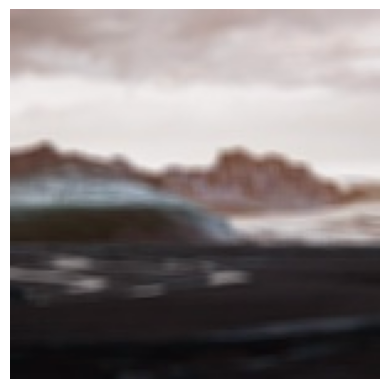

In [7]:

# Load an image
image = cv2.imread('blurred_image.jpg')

# Get image dimensions
height, width,_ = image.shape

print(f"Width: {width}, Height: {height}")
plt.imshow(image)
plt.axis('off')
plt.show()

Width: 150, Height: 150


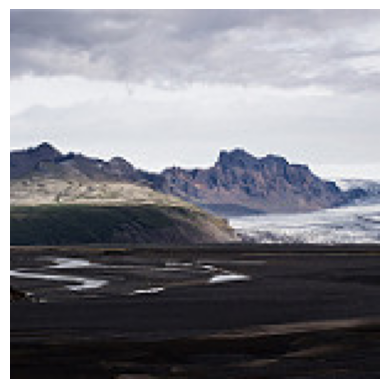

In [8]:
image = cv2.imread('103.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Get image dimensions
height, width,_ = image.shape

print(f"Width: {width}, Height: {height}")
plt.imshow(image)
plt.axis('off')
plt.show()